# Import Libraries

In [2]:
import numpy as np
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D, SimpleRNN
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
import tensorflow_datasets as tfds

# Preprocessing the data
You already learned that we have to tokenize the text before we can feed it into a neural network. This tokenization process will also remove some of the features of the original text, such as all punctuation or words that are less common.

**Below is the AG News Dataset, which contains 120,000 dataset and 4 classes**

In [8]:
dataset = tfds.load('ag_news_subset', split='train', shuffle_files=True, download=True)

texts, target = [], []
for example in dataset:
  texts.append(example["description"].numpy().decode('utf-8'))
  target.append(example["label"].numpy())

target_names = ['world','sports','business','sci/tech']

In [6]:
print (target[:10])

print (len(texts))
print (len(target))
print (len(texts[0].split()))
print (texts[0])
print (target[0])
print (target_names[target[0]])

[3, 1, 2, 3, 1, 0, 3, 0, 0, 1]
120000
120000
20
AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
3
sci/tech


Remember we have to specify the size of our vocabulary. Words that are less frequent will get removed. In this case we want to retain the **10,000** most common words.

In [12]:
vocab_size = 10000 #define the vocabulary size

Tokenizer = Tokenizer(num_words = vocab_size) # Setup tokenizer
Tokenizer.fit_on_texts(texts) #fitting the tokenizer on the data
sequences = Tokenizer.texts_to_sequences(texts) # Generate sequences

In [14]:
print (Tokenizer.texts_to_sequences(['Hello King, how are you?']))

print (len(sequences))
print (len(sequences[0]))
print (sequences[0])

[[1544, 324, 33, 171]]
120000
22
[1541, 9, 10, 21, 2452, 1752, 5047, 621, 17, 796, 4787, 8, 721, 1762, 995, 279, 7851, 249, 247, 6, 350, 6185]


In [15]:
word_index = Tokenizer.word_index
print('Found {:,} unique words.'.format(len(word_index)))

Found 63,738 unique words.


Our text is now converted to sequences of numbers. It makes sense to convert some of those sequences back into text to check what the tokenization did to our text. To this end we create an inverse index that maps numbers to words while the tokenizer maps words to numbers.

In [16]:
# Create inverse index mapping numbers to words
inv_index = {v: k for k, v in Tokenizer.word_index.items()}

# Print out text again
for w in sequences[0]:
    x = inv_index.get(w)
    print(x,end = ' ')

amd 39 s new dual core opteron chip is designed mainly for corporate computing applications including databases web services and financial transactions 

# Measuring text length
Let's ensure all sequences have the same length.

In [17]:
# Get the average length of a text
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(30.389458333333334, 10.466547371184697)

You can see, the average text is about 31 words long. However, the standard deviation is quite small which indicates that some texts are much shorter. We will restrict sequence length to 30 words. You should try out some different sequence lengths and experiment with processing time and accuracy gains.

In [18]:
print(pad_sequences([[1,2,3]], maxlen=5))
print(pad_sequences([[1,2,3,4,5,6]], maxlen=5))

[[0 0 1 2 3]]
[[2 3 4 5 6]]


In [19]:
max_length = 30 #set the maximum length of the each data
data = pad_sequences(sequences, max_length) #padding each data

# Turning labels into One-Hot encodings
Labels can quickly be encoded into one-hot vectors with Keras:

In [20]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(target))
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

print (target[0])
print (labels[0])

Shape of data: (120000, 30)
Shape of labels: (120000, 4)
3
[0. 0. 0. 1.]


# Split dataset into training and testing data

In [21]:
train_size = int(len(data) * .8) #set training data size
xtrain = data[:train_size]
ytrain = labels[:train_size]

xtest = data[train_size:]
ytest = labels[train_size:]

xtest_texts = texts[train_size:]

# Create Model (MLP)

In [28]:
modelNN = Sequential()
modelNN.add(Input(shape=(max_length,)))
modelNN.add(Activation('relu'))
modelNN.add(Dense(64,activation='sigmoid'))
modelNN.add(Dense(32,activation='sigmoid'))
modelNN.add(Dense(4,activation='softmax'))
modelNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation (Activation)      (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 4,196
Trainable params: 4,196
Non-trainable params: 0
_________________________________________________________________


In [29]:
modelNN.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[categorical_accuracy])

histNN = modelNN.fit(xtrain,ytrain,validation_split=0.2,epochs=10)

Epoch 1/10
2400/2400 [==============================] - 8s 2ms/step - loss: 1.3923 - categorical_accuracy: 0.2659 - val_loss: 1.3817 - val_categorical_accuracy: 0.2816
Epoch 2/10
2400/2400 [==============================] - 5s 2ms/step - loss: 1.3823 - categorical_accuracy: 0.2811 - val_loss: 1.3834 - val_categorical_accuracy: 0.2793
Epoch 3/10
2400/2400 [==============================] - 5s 2ms/step - loss: 1.3799 - categorical_accuracy: 0.2829 - val_loss: 1.3805 - val_categorical_accuracy: 0.2819
Epoch 4/10
2400/2400 [==============================] - 5s 2ms/step - loss: 1.3788 - categorical_accuracy: 0.2835 - val_loss: 1.3790 - val_categorical_accuracy: 0.2839
Epoch 5/10
2400/2400 [==============================] - 5s 2ms/step - loss: 1.3771 - categorical_accuracy: 0.2915 - val_loss: 1.3794 - val_categorical_accuracy: 0.2809
Epoch 6/10
2400/2400 [==============================] - 5s 2ms/step - loss: 1.3759 - categorical_accuracy: 0.2946 - val_loss: 1.3766 - val_categorical_accuracy:

# Create Model (Simple RNN)

In [31]:
modelRNN = Sequential()
modelRNN.add(Embedding(input_dim=vocab_size,
                       output_dim=64,
                       input_length=max_length,
                       trainable=True))
modelRNN.add(SimpleRNN(64))
modelRNN.add(Dense(4,activation='softmax'))
modelRNN.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            640000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 648,516
Trainable params: 648,516
Non-trainable params: 0
_________________________________________________________________


In [32]:
# https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
modelRNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

histRNN = modelRNN.fit(xtrain, ytrain, validation_split=0.2, epochs=2)

Epoch 1/2
2400/2400 [==============================] - 44s 18ms/step - loss: 0.6418 - categorical_accuracy: 0.7471 - val_loss: 0.3829 - val_categorical_accuracy: 0.8760
Epoch 2/2
2400/2400 [==============================] - 44s 18ms/step - loss: 0.2875 - categorical_accuracy: 0.9049 - val_loss: 0.3750 - val_categorical_accuracy: 0.8814


# Create Model (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
modelLSTM = ???

In [ ]:
# https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

histLSTM = modelLSTM.fit(xtrain, ytrain, validation_split=0.2, epochs=2)

# Create Model (CNN)

In [33]:
modelCNN = Sequential()
modelCNN.add(Embedding(input_dim=vocab_size,
                       output_dim=64,
                       input_length=max_length,
                       trainable=True))
modelCNN.add(Conv1D(64,2,activation='relu'))
modelCNN.add(MaxPooling1D(2))
modelCNN.add(Conv1D(64,2,activation='relu'))
modelCNN.add(MaxPooling1D(2))
modelCNN.add(Flatten())
modelCNN.add(Dense(64,activation='relu'))
modelCNN.add(Dense(4,activation='softmax'))
modelCNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 64)            640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 64)            8256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [34]:
# https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

histCNN = modelCNN.fit(xtrain, ytrain, validation_split=0.2, epochs=2)

Epoch 1/2
2400/2400 [==============================] - 49s 8ms/step - loss: 0.6145 - categorical_accuracy: 0.7464 - val_loss: 0.3370 - val_categorical_accuracy: 0.8851
Epoch 2/2
2400/2400 [==============================] - 19s 8ms/step - loss: 0.2542 - categorical_accuracy: 0.9116 - val_loss: 0.3481 - val_categorical_accuracy: 0.8810


Our model achieves 66% accuracy on the validation set. Systems like these can be used to assign emails in customer support centers, suggest responses, or classify other forms of text like invoices which need to be assigned to an department. Let's take a look at how our model classified one of the texts:

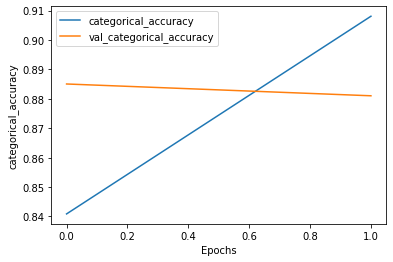

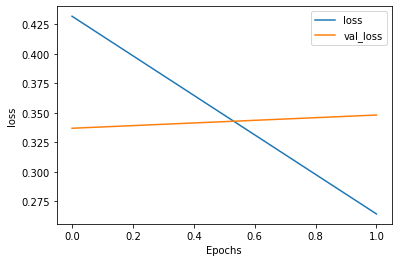

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(histCNN, "categorical_accuracy")
plot_graphs(histCNN, "loss")

# Example Prediction

In [36]:
example = xtest[1000] # get the tokens
print (xtest_texts[1000])

# Print tokens as text
for w in example:
    x = inv_index.get(w)
    print(x,end = ' ')

Despite walloping Colorado State, 63-31, to extend their record to a school-best 9-0, the Utes watch their ranking in the Bowl Championships Series standings drop a spot to seventh.
despite colorado state 63 31 to extend their record to a school best 9 0 the watch their ranking in the bowl championships series standings drop a spot to seventh 

In [37]:
# Get prediction
pred = modelCNN.predict(example.reshape(1,30))

In [38]:
# Output predicted category
target_names[np.argmax(pred)]

'sports'